## **Installation**

In [1]:
!pip -q install umap-learn xgboost


## 2.**Imports** **bold text**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score
%matplotlib inline


## **3.Load Dataset**

In [3]:
path = "/content/kidney_disease.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())
print("\nTarget distribution:\n", df["classification"].value_counts())


Shape: (400, 26)
Columns: ['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'classification']


,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35,7300,4.6,no,no,no,good,no,no,ckd



Target distribution:
 classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64


## 4.**Clean strings + create label (y)**

---



In [4]:
# Strip whitespace in ALL string cells
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Replace common "missing" tokens with NaN
df = df.replace(["?", "??", "NA", "N/A", "", "nan", "NaN"], np.nan)

# Label: ckd=1, notckd=0
y = df["classification"].replace({"ckd": 1, "notckd": 0}).astype(int)

# Features (drop id + classification)
X = df.drop(columns=["classification"])
if "id" in X.columns:
    X = X.drop(columns=["id"])

print("✅ y mapping:", y.unique(), "(1=ckd, 0=notckd)")
print("X shape:", X.shape)


✅ y mapping: [1 0] (1=ckd, 0=notckd)
X shape: (400, 24)


/tmp/ipython-input-4028455015.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipython-input-4028455015.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df["classification"].replace({"ckd": 1, "notckd": 0}).astype(int)


## **5.Detect numeric vs categorical columns**





In [5]:
# Convert numeric-looking columns to numeric safely
X2 = X.copy()
for col in X2.columns:
    # if a column has numbers stored as text, coerce it
    X2[col] = pd.to_numeric(X2[col], errors="ignore")

# Identify numeric/categorical by dtype
numeric_cols = X2.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = [c for c in X2.columns if c not in numeric_cols]

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)


Numeric cols: ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc']
Categorical cols: ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']


/tmp/ipython-input-47308386.py:5: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  X2[col] = pd.to_numeric(X2[col], errors="ignore")


## **6.Train/Test split + preprocessing pipeline (Impute + OHE + Scale)**

In [6]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, random_state=42, stratify=y
)

# OneHotEncoder compatibility (some sklearn uses sparse_output, old uses sparse)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols)
    ],
    remainder="drop"
)

# Fit on train only
X_train_proc = preprocess.fit_transform(X_train_raw)
X_test_proc  = preprocess.transform(X_test_raw)

print("✅ Processed train shape:", X_train_proc.shape)
print("✅ Processed test shape:", X_test_proc.shape)


✅ Processed train shape: (320, 34)
✅ Processed test shape: (80, 34)


## **7.DR + plotting functions**

In [7]:
def get_dr_embeddings(X_mat, method="pca", random_state=42):
    if method == "none":
        return X_mat
    if method == "pca":
        return PCA(n_components=2, random_state=random_state).fit_transform(X_mat)
    if method == "tsne":
        return TSNE(
            n_components=2, perplexity=30, learning_rate="auto",
            init="pca", random_state=random_state
        ).fit_transform(X_mat)
    if method == "umap":
        return umap.UMAP(n_components=2, random_state=random_state).fit_transform(X_mat)
    raise ValueError("Unknown DR method")

def plot_2d(X_2d, labels, title):
    plt.figure(figsize=(7,6))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=25)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(label="Cluster ID")
    plt.tight_layout()
    plt.show()


## **8.Clustering + scoring functions**





In [8]:
def safe_cluster_scores(X_emb, labels):
    uniq = set(labels)
    if len(uniq) <= 1:
        return None

    # DBSCAN noise case (-1)
    if -1 in uniq:
        mask = labels != -1
        if mask.sum() < 10:
            return None
        X_nn = X_emb[mask]
        y_nn = labels[mask]
        if len(set(y_nn)) <= 1:
            return None
        sil = silhouette_score(X_nn, y_nn)
        dbi = davies_bouldin_score(X_nn, y_nn)
        chi = calinski_harabasz_score(X_nn, y_nn)
        return sil, dbi, chi

    sil = silhouette_score(X_emb, labels)
    dbi = davies_bouldin_score(X_emb, labels)
    chi = calinski_harabasz_score(X_emb, labels)
    return sil, dbi, chi

def run_clustering(X_emb, algo, k=3, eps=0.6, min_samples=5, random_state=42):
    if algo == "kmeans":
        return KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit_predict(X_emb)
    if algo == "hierarchical":
        return AgglomerativeClustering(n_clusters=k).fit_predict(X_emb)
    if algo == "dbscan":
        return DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_emb)
    raise ValueError("Unknown clustering algorithm")


## **9.Benchmark all DR × clustering combos**

In [9]:
dr_methods = ["none", "pca", "tsne", "umap"]
cluster_algos = ["kmeans", "hierarchical", "dbscan"]

rows = []
for dr in dr_methods:
    X_emb = get_dr_embeddings(X_train_proc, method=dr, random_state=42)

    for algo in cluster_algos:
        if algo in ["kmeans", "hierarchical"]:
            for k in [2, 3, 4, 5]:
                labels = run_clustering(X_emb, algo=algo, k=k, random_state=42)
                scores = safe_cluster_scores(X_emb, labels)
                if scores is None:
                    continue
                sil, dbi, chi = scores
                rows.append([dr, algo, f"k={k}", sil, dbi, chi, len(set(labels))])

        if algo == "dbscan":
            for eps in [0.3, 0.5, 0.7, 0.9, 1.1]:
                labels = run_clustering(X_emb, algo=algo, eps=eps, min_samples=5, random_state=42)
                scores = safe_cluster_scores(X_emb, labels)
                if scores is None:
                    continue
                sil, dbi, chi = scores
                rows.append([dr, algo, f"eps={eps}", sil, dbi, chi, len(set(labels))])

bench = pd.DataFrame(rows, columns=[
    "DR", "Clustering", "Params", "Silhouette(↑)", "DBI(↓)", "CH(↑)", "NumClusters"
]).sort_values("Silhouette(↑)", ascending=False).reset_index(drop=True)

print("✅ Benchmark done. Top 10 results:")
display(bench.head(10))


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Benchmark done. Top 10 results:


,DR,Clustering,Params,Silhouette(↑),DBI(↓),CH(↑),NumClusters
0,tsne,dbscan,eps=1.1,0.871251,0.160664,272.045593,3
1,umap,hierarchical,k=2,0.538174,0.679651,550.334656,2
2,umap,kmeans,k=2,0.537848,0.684068,557.304321,2
3,tsne,kmeans,k=2,0.524774,0.689942,566.226196,2
4,pca,dbscan,eps=0.3,0.518049,0.544652,409.416058,4
5,tsne,hierarchical,k=2,0.502701,0.674541,478.842529,2
6,pca,kmeans,k=4,0.493493,0.816775,336.969551,4
7,pca,kmeans,k=2,0.489418,0.745471,329.942537,2
8,pca,kmeans,k=3,0.489018,0.884063,313.944320,3
9,pca,kmeans,k=5,0.463614,0.839305,323.151187,5


## **10.Plot “Top 5 visualizable” results**

===== TOP VISUALIZABLE (2D) CLUSTER PLOTS =====


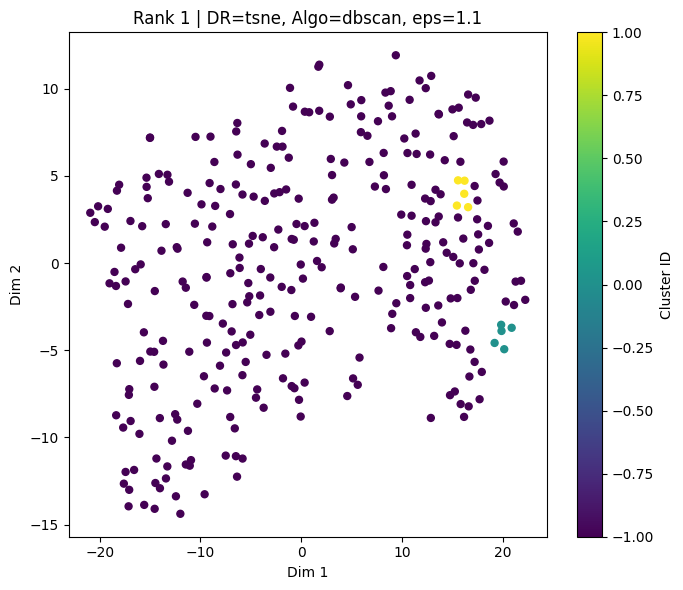

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


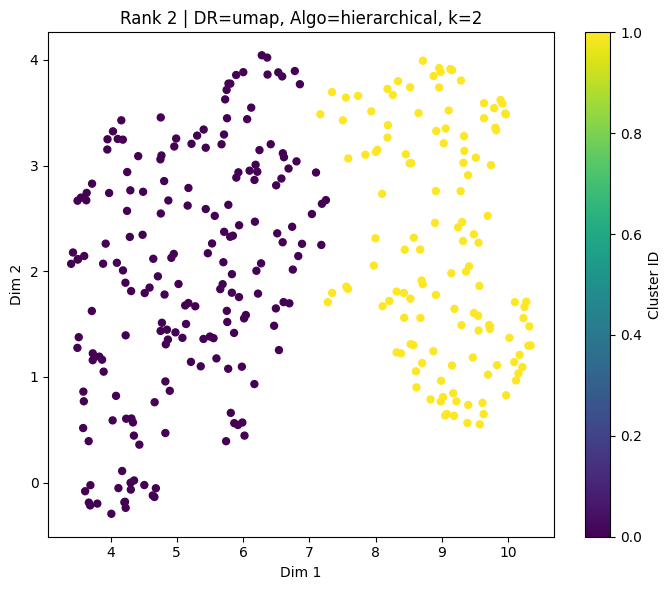

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


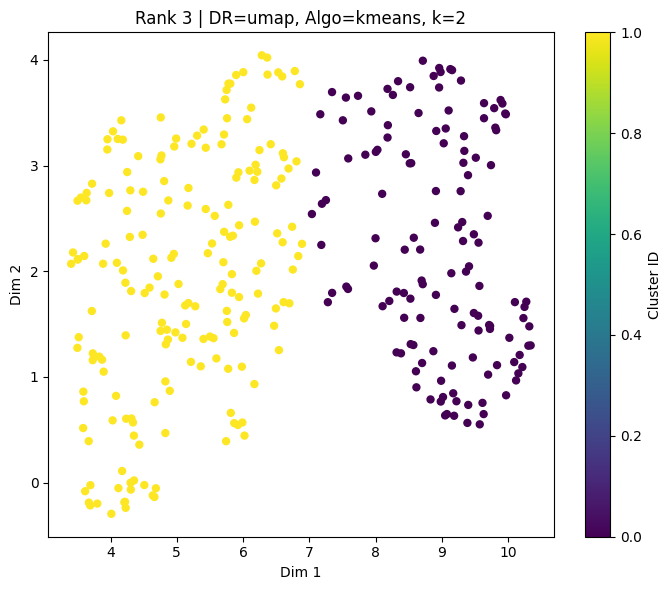

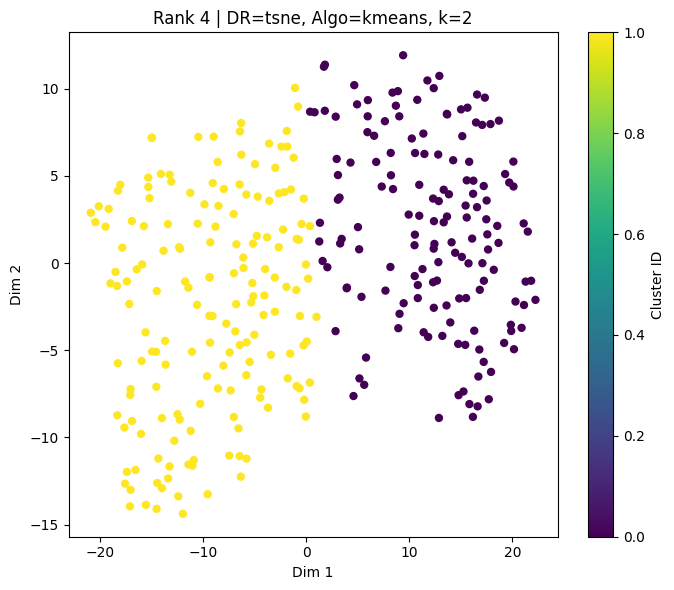

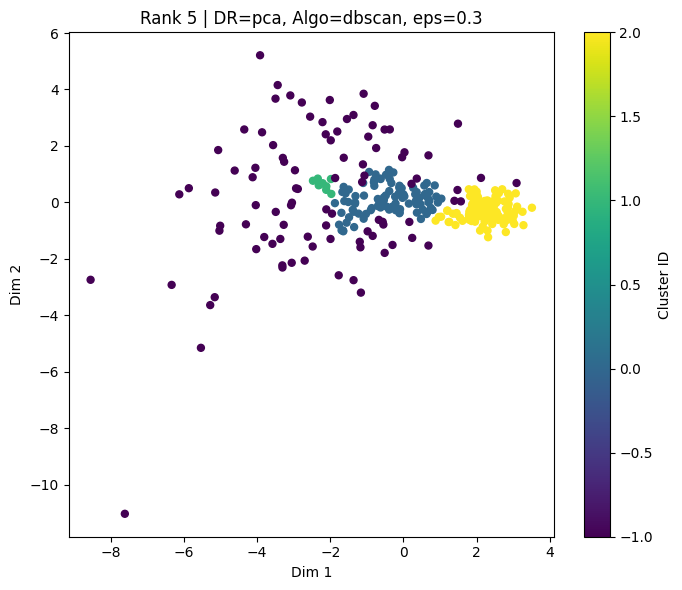

In [10]:
print("===== TOP VISUALIZABLE (2D) CLUSTER PLOTS =====")

shown = 0
for i in range(len(bench)):
    row = bench.iloc[i]
    dr = row["DR"]
    if dr == "none":
        continue  # cannot visualize in 2D

    algo = row["Clustering"]
    params = row["Params"]

    k_tmp, eps_tmp = 3, 0.6
    if str(params).startswith("k="):
        k_tmp = int(str(params).split("=")[1])
    if str(params).startswith("eps="):
        eps_tmp = float(str(params).split("=")[1])

    X_tmp = get_dr_embeddings(X_train_proc, method=dr, random_state=42)
    labels_tmp = run_clustering(X_tmp, algo=algo, k=k_tmp, eps=eps_tmp, random_state=42)

    plot_2d(X_tmp, labels_tmp, f"Rank {i+1} | DR={dr}, Algo={algo}, {params}")
    shown += 1
    if shown == 5:
        break

if shown == 0:
    print("No 2D results available. Try removing t-SNE or adjust DBSCAN eps range.")


## **11.Pick best result + create cluster labels on TRAIN (for interpretation)**

✅ BEST CONFIG:
DR                     tsne
Clustering           dbscan
Params              eps=1.1
Silhouette(↑)      0.871251
DBI(↓)             0.160664
CH(↑)            272.045593
NumClusters               3
Name: 0, dtype: object


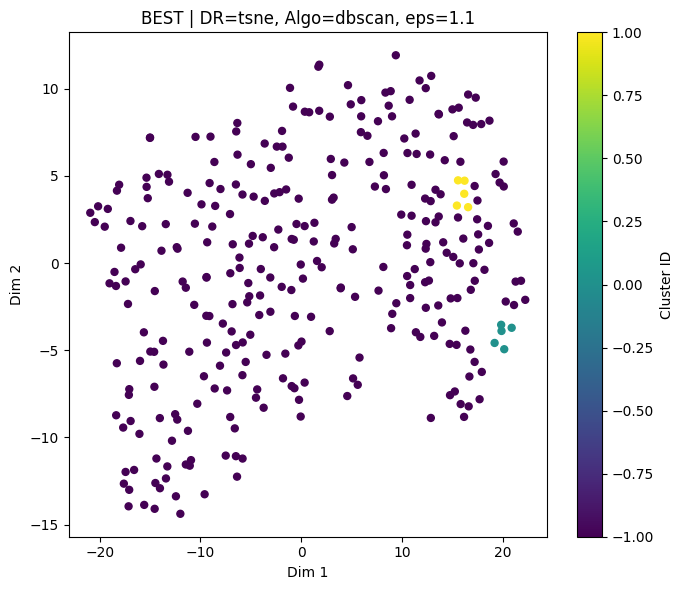

In [11]:
best = bench.iloc[0]
best_dr = best["DR"]
best_algo = best["Clustering"]
best_params = best["Params"]

k_best, eps_best = 3, 0.6
if str(best_params).startswith("k="):
    k_best = int(str(best_params).split("=")[1])
if str(best_params).startswith("eps="):
    eps_best = float(str(best_params).split("=")[1])

print("✅ BEST CONFIG:")
print(best)

X_best_2d = get_dr_embeddings(X_train_proc, method=best_dr, random_state=42)
labels_best = run_clustering(X_best_2d, algo=best_algo, k=k_best, eps=eps_best, random_state=42)

if best_dr != "none":
    plot_2d(X_best_2d, labels_best, f"BEST | DR={best_dr}, Algo={best_algo}, {best_params}")
else:
    print("Best DR=none → best scoring in high dimension; choose PCA/UMAP rows for plotting.")


/content/diabetes.csv

## **12.Interpret clusters into Low/Medium/High Risk**





In [12]:
# Make an interpretable TRAIN dataframe (original columns, cleaned)
train_df = X_train_raw.reset_index(drop=True).copy()
train_df["cluster_id"] = labels_best
train_df["ckd_label"] = y_train.reset_index(drop=True).values  # only for interpretation

# Convert numeric columns again (some might still be object)
for col in numeric_cols:
    if col in train_df.columns:
        train_df[col] = pd.to_numeric(train_df[col], errors="coerce")

# Cluster summary table
summary = train_df.groupby("cluster_id").agg(
    n=("ckd_label", "count"),
    ckd_rate=("ckd_label", "mean"),
    mean_sc=("sc", "mean") if "sc" in train_df.columns else ("ckd_label", "mean"),
    mean_bu=("bu", "mean") if "bu" in train_df.columns else ("ckd_label", "mean"),
    mean_bp=("bp", "mean") if "bp" in train_df.columns else ("ckd_label", "mean"),
    mean_hemo=("hemo", "mean") if "hemo" in train_df.columns else ("ckd_label", "mean"),
    mean_sg=("sg", "mean") if "sg" in train_df.columns else ("ckd_label", "mean"),
).reset_index()

# Risk score (feature-based)
# Higher sc, bu, bp => higher risk
# Lower hemo, sg => higher risk (use inverse rank)
def r(col):
    return summary[col].rank(pct=True) if col in summary.columns else 0

summary["risk_score"] = (
    r("mean_sc") +
    r("mean_bu") +
    r("mean_bp") +
    (1 - r("mean_hemo")) +
    (1 - r("mean_sg"))
)

summary = summary.sort_values("risk_score").reset_index(drop=True)

# Assign risk labels
if len(summary) >= 3:
    labels = ["Low-risk", "Medium-risk", "High-risk"] + ["High-risk"]*(len(summary)-3)
elif len(summary) == 2:
    labels = ["Low-risk", "High-risk"]
else:
    labels = ["Single-group"]

summary["risk_label"] = labels[:len(summary)]

print("===== CLUSTER INTERPRETATION TABLE  =====")
display(summary)

cluster_to_risk = dict(zip(summary["cluster_id"], summary["risk_label"]))
print("Cluster → Risk:", cluster_to_risk)


===== CLUSTER INTERPRETATION TABLE  =====


,cluster_id,n,ckd_rate,mean_sc,mean_bu,mean_bp,mean_hemo,mean_sg,risk_score,risk_label
0,1,5,0.000000,0.98000,28.200000,62.000000,16.58000,1.023000,1.666667,Low-risk
1,0,5,0.000000,0.88000,27.400000,76.000000,14.58000,1.020000,2.000000,Medium-risk
2,-1,310,0.645161,3.22381,58.464605,77.023411,12.40412,1.017241,4.333333,High-risk


Cluster → Risk: {1: 'Low-risk', 0: 'Medium-risk', -1: 'High-risk'}


## **13.Plot with “Low/Medium/High” written on clusters (if 2D)**

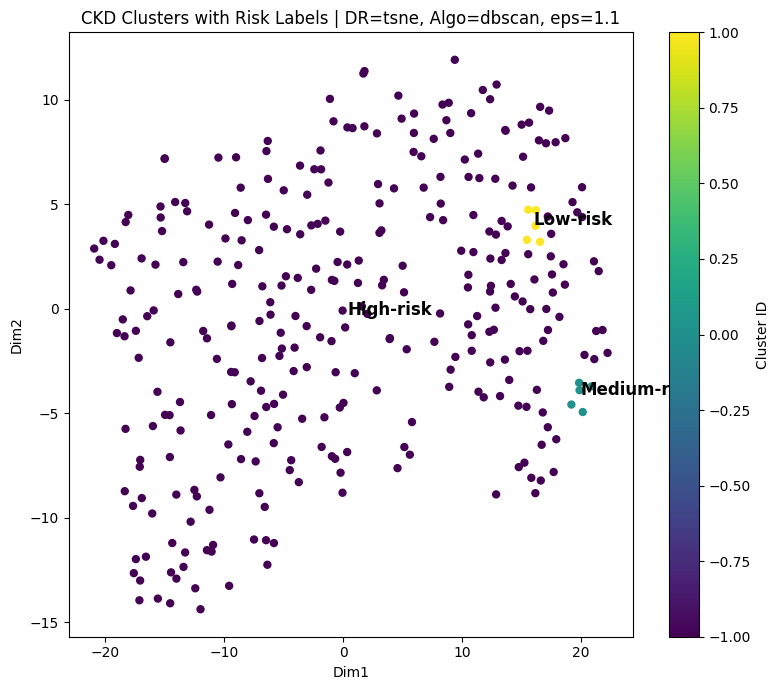

In [13]:
import numpy as np

if best_dr != "none":
    plt.figure(figsize=(8,7))
    plt.scatter(X_best_2d[:,0], X_best_2d[:,1], c=labels_best, s=25)
    plt.title(f"CKD Clusters with Risk Labels | DR={best_dr}, Algo={best_algo}, {best_params}")
    plt.xlabel("Dim1"); plt.ylabel("Dim2")
    plt.colorbar(label="Cluster ID")

    for cid in np.unique(labels_best):
        pts = X_best_2d[labels_best == cid]
        cx, cy = pts.mean(axis=0)
        plt.text(cx, cy, cluster_to_risk.get(cid, f"Cluster {cid}"), fontsize=12, weight="bold")

    plt.tight_layout()
    plt.show()
else:
    print("Best DR=none so cannot label on 2D plot. Use PCA/UMAP plot from Cell 10 for visuals.")


## **14.Classification: Without vs With cluster-feature**

In [14]:
# Cluster-as-feature (KMeans in high-dimensional processed space)
cluster_k = 3
kmeans_feat = KMeans(n_clusters=cluster_k, random_state=42, n_init="auto")
train_cluster_feat = kmeans_feat.fit_predict(X_train_proc)
test_cluster_feat  = kmeans_feat.predict(X_test_proc)

X_train_plus = np.column_stack([X_train_proc, train_cluster_feat])
X_test_plus  = np.column_stack([X_test_proc,  test_cluster_feat])

models = [
    ("LogReg", LogisticRegression(max_iter=4000)),
    ("RandomForest", RandomForestClassifier(n_estimators=400, random_state=42)),
    ("XGBoost", XGBClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, eval_metric="logloss"
    ))
]

def eval_models(Xtr, Xte, ytr, yte, title):
    print("\n====", title, "====")
    rows = []
    for name, model in models:
        model.fit(Xtr, ytr)
        pred = model.predict(Xte)
        acc = accuracy_score(yte, pred)
        f1  = f1_score(yte, pred)
        rows.append([name, acc, f1])
        print(f"{name}: Accuracy={acc:.4f} | F1={f1:.4f}")
    return pd.DataFrame(rows, columns=["Model","Accuracy","F1"])

base = eval_models(X_train_proc, X_test_proc, y_train, y_test, "WITHOUT cluster feature")
plus = eval_models(X_train_plus, X_test_plus, y_train, y_test, "WITH cluster feature")

final = base.merge(plus, on="Model", suffixes=("_NoCluster", "_WithCluster"))
final["Acc_Improve"] = final["Accuracy_WithCluster"] - final["Accuracy_NoCluster"]
final["F1_Improve"]  = final["F1_WithCluster"] - final["F1_NoCluster"]

print("\n===== FINAL COMPARISON TABLE =====")
display(final.sort_values("Acc_Improve", ascending=False))



==== WITHOUT cluster feature ====
LogReg: Accuracy=0.9875 | F1=0.9899
RandomForest: Accuracy=1.0000 | F1=1.0000
XGBoost: Accuracy=1.0000 | F1=1.0000

==== WITH cluster feature ====
LogReg: Accuracy=0.9750 | F1=0.9796
RandomForest: Accuracy=1.0000 | F1=1.0000
XGBoost: Accuracy=1.0000 | F1=1.0000

===== FINAL COMPARISON TABLE =====


,Model,Accuracy_NoCluster,F1_NoCluster,Accuracy_WithCluster,F1_WithCluster,Acc_Improve,F1_Improve
1,RandomForest,1.0000,1.000000,1.000,1.000000,0.0000,0.000000
2,XGBoost,1.0000,1.000000,1.000,1.000000,0.0000,0.000000
0,LogReg,0.9875,0.989899,0.975,0.979592,-0.0125,-0.010307


## **15. 5-Fold Cross Validation (strong validity evidence)**




In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_score(model, X, y):
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean()
    f1  = cross_val_score(model, X, y, cv=cv, scoring="f1").mean()
    return acc, f1

rows = []
for name, model in models:
    acc, f1 = cv_score(model, X_train_proc, y_train)
    rows.append([name, "NoCluster", acc, f1])

for name, model in models:
    acc, f1 = cv_score(model, X_train_plus, y_train)
    rows.append([name, "WithCluster", acc, f1])

cv_df = pd.DataFrame(rows, columns=["Model","Setting","CV_Accuracy","CV_F1"])
print("===== 5-FOLD CV RESULTS =====")
display(cv_df)


===== 5-FOLD CV RESULTS =====


,Model,Setting,CV_Accuracy,CV_F1
0,LogReg,NoCluster,0.993750,0.994999
1,RandomForest,NoCluster,0.993750,0.995062
2,XGBoost,NoCluster,0.981250,0.985123
3,LogReg,WithCluster,0.984375,0.987145
4,RandomForest,WithCluster,0.990625,0.992468
5,XGBoost,WithCluster,0.978125,0.982276


## **16. CKD: Disease rate by cluster + Boxplots**

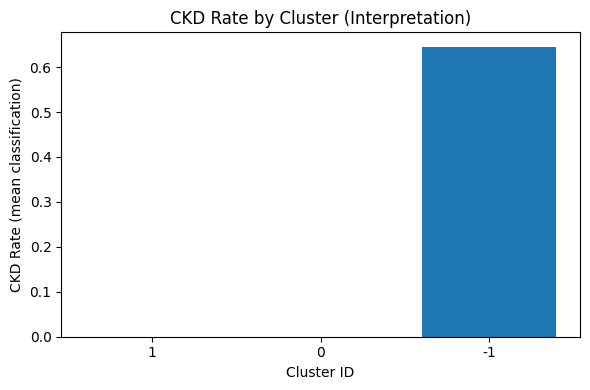

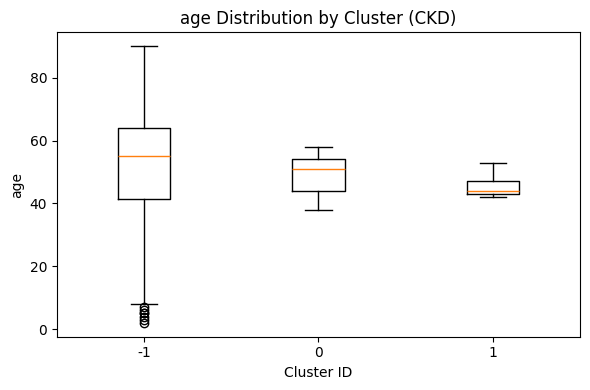

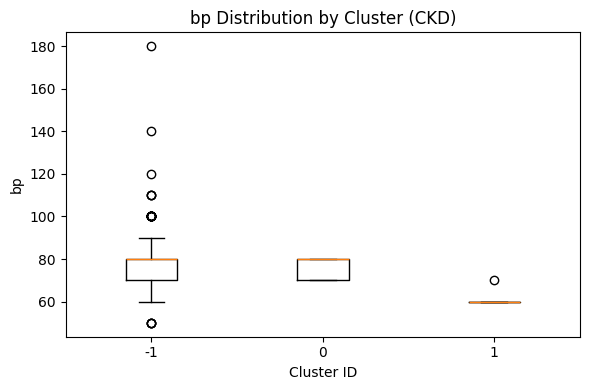

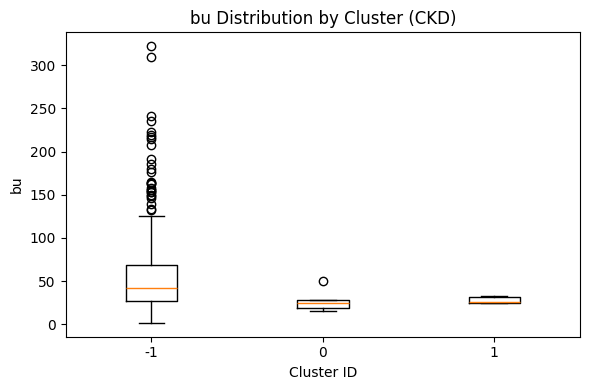

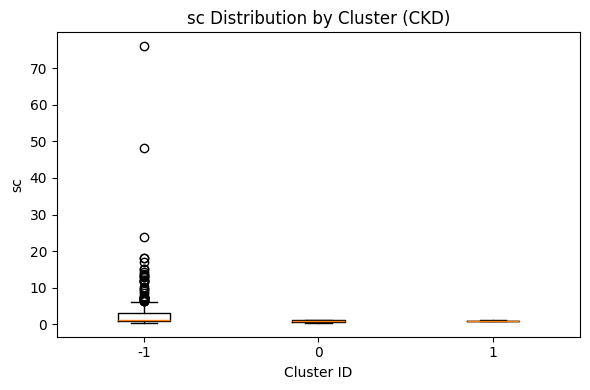

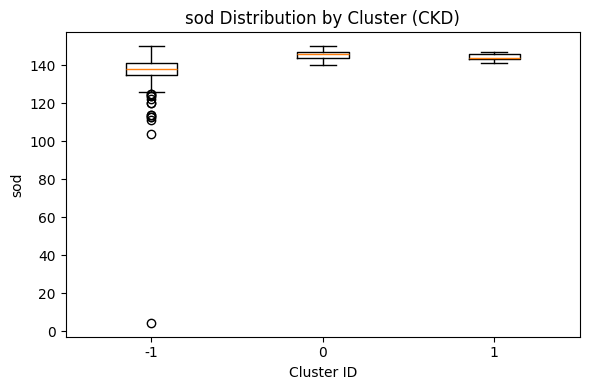

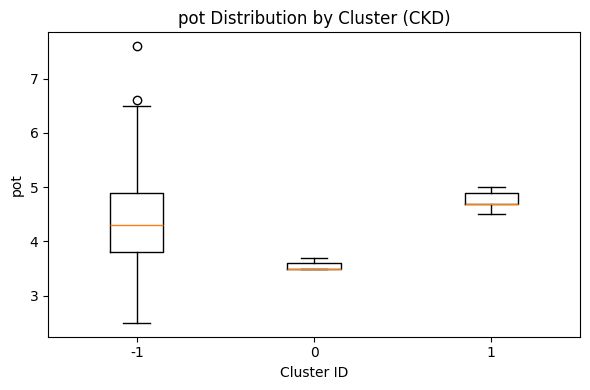

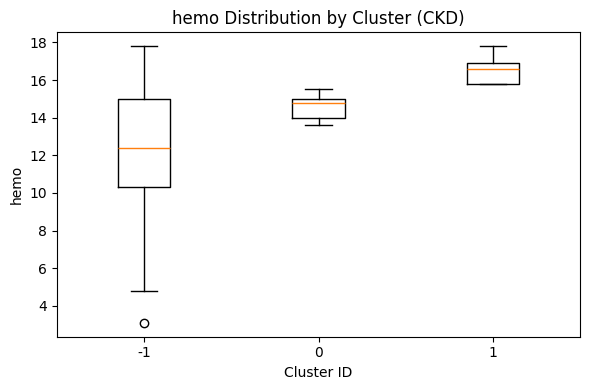

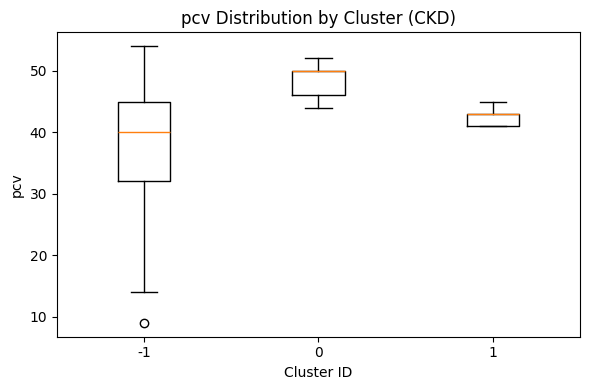

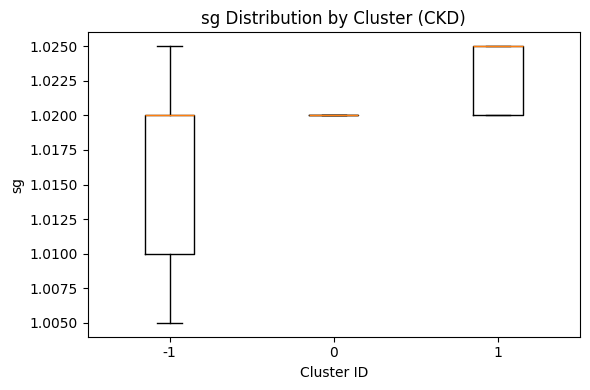

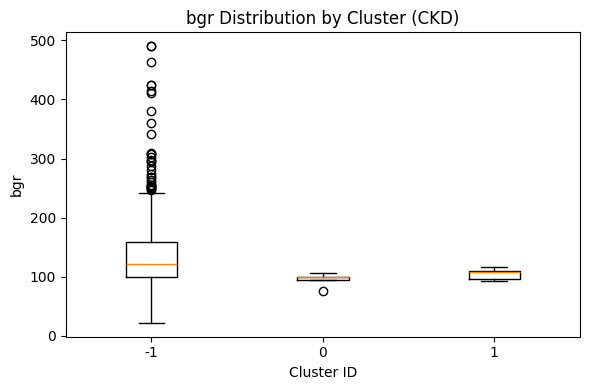

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Disease rate by cluster (bar chart) ---
plt.figure(figsize=(6,4))
plt.bar(summary["cluster_id"].astype(str), summary["ckd_rate"])
plt.title("CKD Rate by Cluster (Interpretation)")
plt.xlabel("Cluster ID")
plt.ylabel("CKD Rate (mean classification)")
plt.tight_layout()
plt.show()

# --- 2) Boxplots for key CKD risk features (only those present) ---
# Important CKD indicators:
# sc (serum creatinine) ↑ risk
# bu (blood urea) ↑ risk
# bp (blood pressure) ↑ risk
# hemo (hemoglobin) ↓ risk
# sg (specific gravity) ↓ risk
features_to_show = [c for c in ["age", "bp", "bu", "sc", "sod", "pot", "hemo", "pcv", "sg", "bgr"] if c in train_df.columns]

# Ensure numeric conversion for plotting
for c in features_to_show:
    train_df[c] = pd.to_numeric(train_df[c], errors="coerce")

cluster_ids = sorted(train_df["cluster_id"].unique())

for f in features_to_show:
    plt.figure(figsize=(6,4))
    data = [train_df[train_df["cluster_id"]==cid][f].dropna().values for cid in cluster_ids]
    plt.boxplot(data, tick_labels=[str(cid) for cid in cluster_ids])  # tick_labels works in new matplotlib
    plt.title(f"{f} Distribution by Cluster (CKD)")
    plt.xlabel("Cluster ID")
    plt.ylabel(f)
    plt.tight_layout()
    plt.show()


## **17.Confusion Matrix**

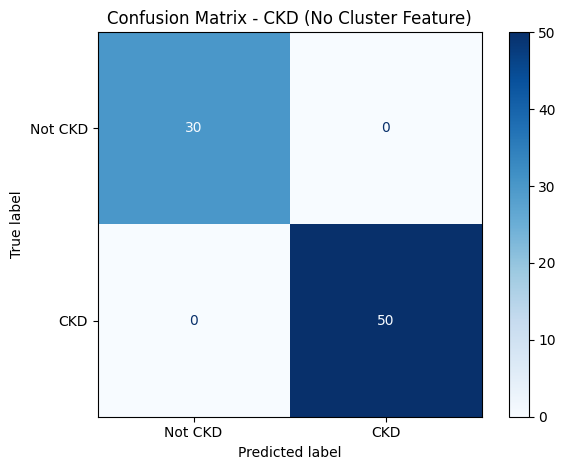

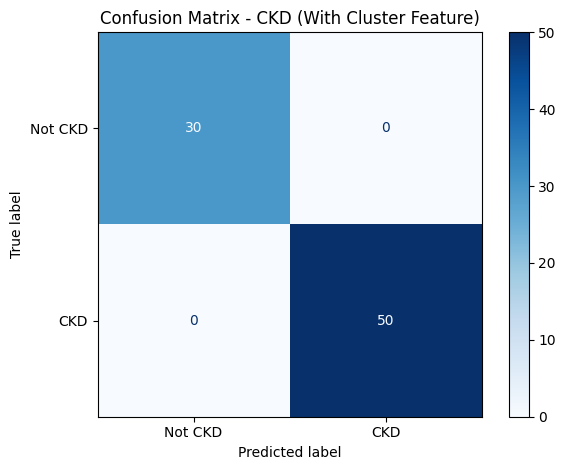

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Not CKD", "CKD"])
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- Case A: Without cluster feature ----
model_no = XGBClassifier(
    n_estimators=600, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, eval_metric="logloss"
)
model_no.fit(X_train_proc, y_train)
pred_no = model_no.predict(X_test_proc)
plot_cm(y_test, pred_no, "Confusion Matrix - CKD (No Cluster Feature)")

# ---- Case B: With cluster feature ----
model_yes = XGBClassifier(
    n_estimators=600, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, eval_metric="logloss"
)
model_yes.fit(X_train_plus, y_train)
pred_yes = model_yes.predict(X_test_plus)
plot_cm(y_test, pred_yes, "Confusion Matrix - CKD (With Cluster Feature)")


## **18.Presion/recall/F1 score**

In [18]:
from sklearn.metrics import classification_report

print("=== No Cluster Feature Report ===")
print(classification_report(y_test, pred_no, target_names=["Not CKD", "CKD"]))

print("\n=== With Cluster Feature Report ===")
print(classification_report(y_test, pred_yes, target_names=["Not CKD", "CKD"]))


=== No Cluster Feature Report ===
              precision    recall  f1-score   support

     Not CKD       1.00      1.00      1.00        30
         CKD       1.00      1.00      1.00        50

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


=== With Cluster Feature Report ===
              precision    recall  f1-score   support

     Not CKD       1.00      1.00      1.00        30
         CKD       1.00      1.00      1.00        50

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [19]:
from sklearn.metrics import roc_auc_score

auc_no = roc_auc_score(y_test, pred_no)
auc_yes = roc_auc_score(y_test, pred_yes)

print("AUC without cluster:", auc_no)
print("AUC with cluster   :", auc_yes)


AUC without cluster: 1.0
AUC with cluster   : 1.0
